In [1]:
#data_path = '../NEextraction/entity_dict.json'
data_path = '../NEextraction/entity_dict_negated.json'

In [2]:
from spacy.tokens import Span


In [3]:
import spacy
import scispacy
from scispacy.linking import EntityLinker

nlp = spacy.load("en_core_sci_md")
nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib
/home/is/seiji-sh/miniconda3/envs/anonymization/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/is/seiji-sh/miniconda3/envs/anonymization/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/is/seiji-sh/miniconda3/envs/anonymization/lib/python3.8/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree

KeyboardInterrupt: 

In [2]:
import json

# read as lines of json
json_list = []
with open(data_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        json_list.append(json.loads(line))


In [3]:
import pandas as pd
df = pd.DataFrame(json_list)
print(len(df))

59652


In [ ]:
linker = nlp.get_pipe("scispacy_linker")

import tqdm

def normalize_disease(entities, threshold=0.8):# Iterate over the list of entities and link them
    normalized_entities = []
    #for entity in entities:
    # tqdm
    for entity in tqdm.tqdm(entities, total=len(entities)):
        # Create a temporary Doc object for the entity text
        doc = nlp.make_doc(entity)
        
        # Manually create a Span for the entity, assuming it spans the whole doc
        span = Span(doc, 0, len(doc), label="ENTITY")
        doc.ents = [span]  # Set the ents attribute to the list containing the span
    
        # Use the EntityLinker to find potential matches
        linked_entities = linker(doc)

        # get the most confident concept name if score > threshold
        best_concept = None
        best_score = 0.0
        
        # Iterate through the linked entities
        for concept_id, score in span._.kb_ents:
            # Only consider concepts above the threshold
            if score > threshold and score > best_score:
                best_score = score
                best_concept = linker.kb.cui_to_entity[concept_id].canonical_name
        
        # Output the most confident concept name and its score
        if best_concept:
            normalized_entities.append(best_concept)
        else:
            normalized_entities.append(entity)

    return normalized_entities

In [ ]:
# extracting only PROBLEM

import re
# iter through rows
doc_ent_list = []
id_list  = []

start_tag_regex = re.compile(r'<e\d+>')
end_tag_regex = re.compile(r'</e\d+>')
        
import tqdm

for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    ent_set = set()
    for ent in list(row['entities']):
        ent = re.sub(start_tag_regex, '', ent)
        ent = re.sub(end_tag_regex, '', ent)
        ent = ent.lower()
        if '[pos]' in ent or '[neg]' in ent:
            ent = re.sub(r'\[pos\]', '', ent)
            ent = re.sub(r'\[neg\]', '', ent)
            if ent != '':
                ent = ent.strip()
                ent_set.add(ent)
        #ent_set.add(ent)    
    id = row['row_id']
    doc_ent_list.append(ent_set)
    id_list.append(id)

100%|██████████| 3707/3707 [00:04<00:00, 786.54it/s]


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer(analyzer=lambda x: x)

X = vectorizer.fit_transform(doc_ent_list)
feature_names = vectorizer.get_feature_names_out()

In [ ]:
normalized_feature_names = normalize_disease(feature_names)

100%|██████████| 65655/65655 [08:12<00:00, 133.37it/s]


In [ ]:
import tqdm
# make dict to map feature names to new columns
feature_dict = dict(zip(feature_names, normalized_feature_names))

new_doc_ent_list = []


#for doc_ent in doc_ent_list:
for doc_ent in tqdm.tqdm(doc_ent_list, total=len(doc_ent_list)):
    new_doc_ent = set()
    for ent in doc_ent:
        if ent.lower() not in feature_dict:
            #new_doc_ent.add(ent.lower())
            print(f'{ent.lower()} not in feature_dict')
        else:
            new_doc_ent.add(feature_dict[ent.lower()])
            
    new_doc_ent_list.append(new_doc_ent)

# create matrix
new_vectorizer = CountVectorizer(analyzer=lambda x: x)
new_X = new_vectorizer.fit_transform(new_doc_ent_list)
new_feature_names = new_vectorizer.get_feature_names_out()

100%|██████████| 3707/3707 [00:00<00:00, 30619.34it/s]


In [ ]:
# copy new_X
import numpy as np

dist = new_X.copy()
# word distribution
dist = dist.sum(axis=0)
dist = np.array(dist).flatten()
word_freq = dict(zip(list(new_feature_names), list(dist)))
sorted_word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))

In [ ]:
# remove obious non-disease words
noise_words = ['Hospital admission', 'the', 'discharge.','Hospitals']
# exact match
# remove obious non-disease words
noise_words = ['Hospital admission', 'the', 'discharge.','Hospitals']
sorted_word_freq = {k: v for k, v in sorted_word_freq.items() if k not in noise_words}


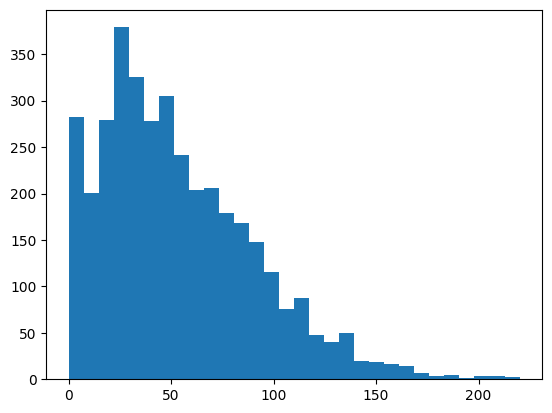

In [ ]:
# dorp noise_words = {'', 'discharge', 'admission', 'transferred', 'admitted', 'hospital1', 'showed', 'discharged', 'revealed','improved', 'hospital', 'home', 'presented', 'resolved', 'presents', 'presentation', 'reports', 'icu', 'states'}
# from new_X

deteted_X = new_X.copy()
deleted_X = deteted_X.tocsr()
deleted_X = deleted_X[:, [i for i, name in enumerate(new_feature_names) if name not in noise_words]]

# the number of words in each document
word_count = deleted_X.sum(axis=1)
word_count = np.array(word_count).flatten()

#plot histogram
plt.hist(word_count, bins=30)
plt.show()

In [ ]:
# frequency-based filtering

# sum of all elements in the matrix
total_freq = sum(sorted_word_freq.values())

# get the column name until the frequency reaches 80%
cum_freq = 0
selected_words = []
for word, freq in sorted_word_freq.items():
    cum_freq += freq
    if freq <= 1:
        break
    elif cum_freq/total_freq >= 0.8:
        break
    selected_words.append(word)
    
    
print(len(sorted_word_freq))
print(len(selected_words))
print(list(selected_words))

53907
14603
['Hospital admission', 'the', 'Surgical transfer - action', 'showed', 'Deciduous maxillary right second molar tooth', 'Body Fluid Discharge', 'Blood', 'aspirin', 'Revealed', 'Hypertensive disease', 'Plain chest X-ray', 'Patient Discharge', 'Hematocrit procedure', 'Dyspnea', 'Presentation', 'Edema', 'Improved', 'Blood pressure determination', 'histidine', 'Chest Pain', 'Coumadin', 'Hospitals', 'Report (document)', 'discharge.', 'Lasix', 'Stable status', 'Herero language', 'vancomycin', 'intensive care unit', 'Intubated', 'refills:*0*', 'Fever', 'Constipation', 'Atrial Fibrillation', 'refills:*2*', 'Aniridia type 1', 'Pain', 'Physical Examination', 'Antibiotics', 'pain.', 'High risk of', 'arrival - ActRelationshipType', 'Vomiting', 'Blood Pressure', 'oxygen', 'Tracheal Extubation', 'Respiratory rate', 'Communicable Diseases', 'Electrocardiogram', 'Heart murmur', 'Hemorrhage', 'denies', 'lisinopril', 'metoprolol', 'Rales', 'Weaning', 'Wheezing', 'Q Fever', 'discharge:', 'Coagu

In [ ]:
selected_words_freq = {selected_word: sorted_word_freq[selected_word] for selected_word in selected_words}
# min value
min_value = min(selected_words_freq.values())
print(min_value)

2


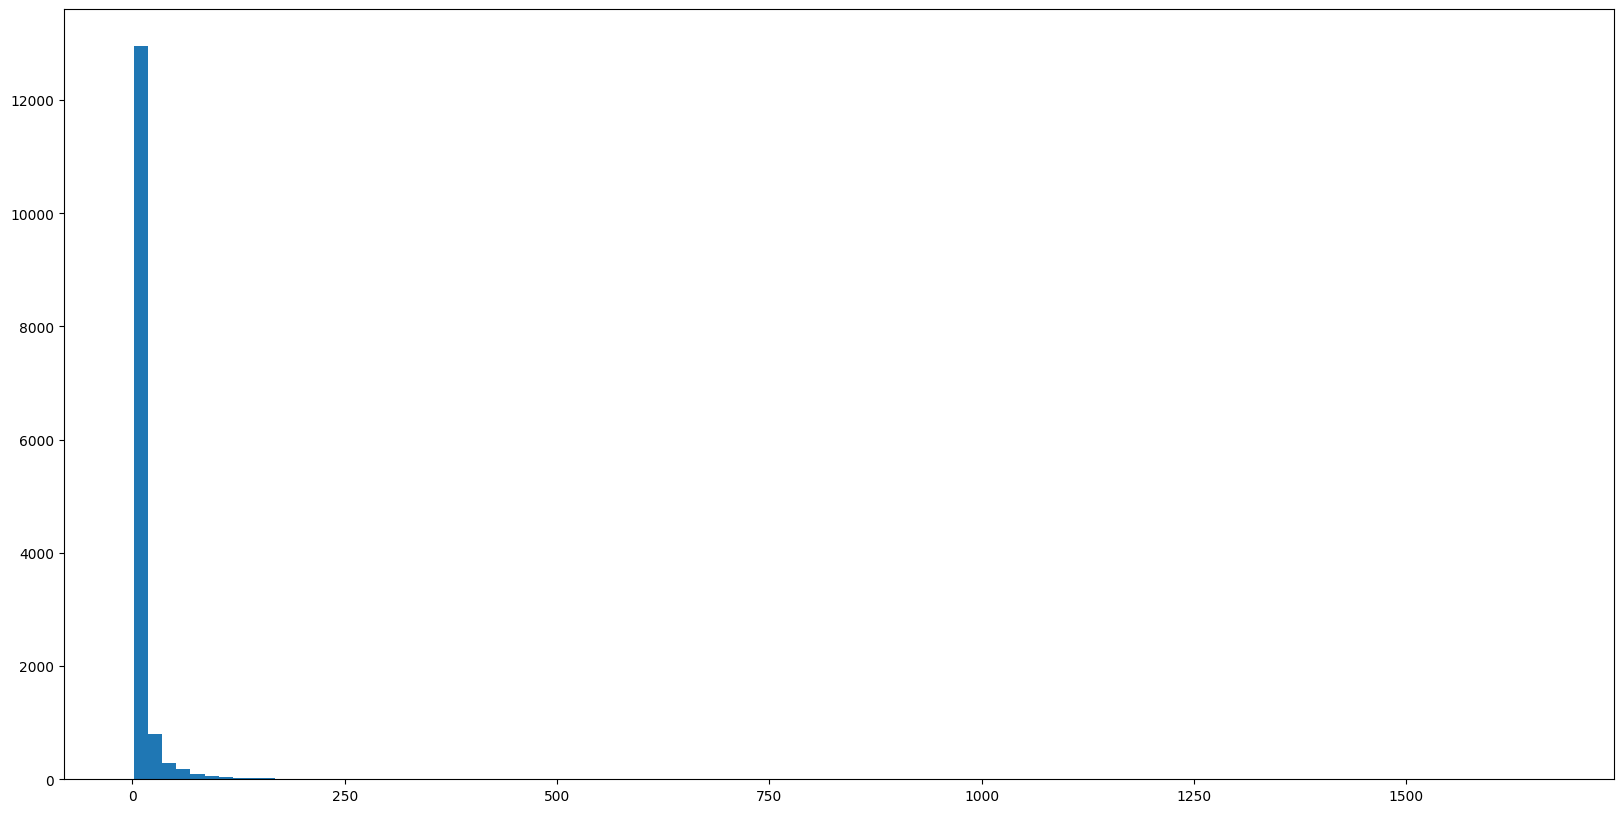

In [ ]:
# plot histogram

plt.figure(figsize=(20, 10))
# bin frequency (values of selected_words_freq)
freq_list = list(selected_words_freq.values())
plt.hist(freq_list, bins=100)
plt.show()


In [ ]:
# re-construct matrix with selected words
selected_words_set = set(selected_words)
final_doc_ent_list = []
for doc_ent in new_doc_ent_list:
    # take intersection with selected_words_set
    new_doc_ent = doc_ent.intersection(selected_words_set)
    final_doc_ent_list.append(new_doc_ent)

# if a value in normalized_dict is not in selected_words, replace with ''
final_normalized_dict = {}
for key, value in feature_dict.items():
    if value in selected_words_set:
        final_normalized_dict[key] = value
    else:
        final_normalized_dict[key] = ''

In [ ]:
final_vectorizer = CountVectorizer(analyzer=lambda x: x)
final_X = final_vectorizer.fit_transform(final_doc_ent_list)
final_feature_names = final_vectorizer.get_feature_names_out()

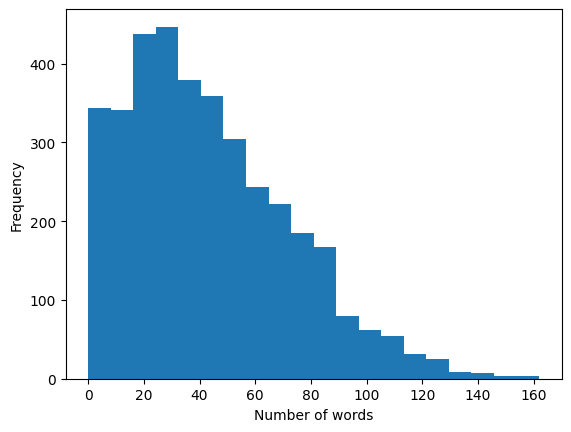

In [ ]:
# average number of words in each document
avg_num_words = final_X.sum(axis=1).mean()

# plot ave number of words as histogram
# per 2 freq
#plt.hist(final_X.sum(axis=1), bins=50)
plt.hist(final_X.sum(axis=1), bins=20)
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# extract only doc contains 5 to 30 words
# get indices of docs with 5 to 30 words
selected_indices = []
for i, row in enumerate(final_X):
    num_words = row.sum()
    #if 5<= num_words <= 40:
    if num_words >= 10 and num_words <= 120:
        selected_indices.append(i)

# get selected rows
selected_X = final_X[selected_indices]

# get selected_indices from id_list

selected_id_list = [id_list[i] for i in selected_indices]

In [ ]:
# sample 100 ids from selected_indices
sampled_indices = np.random.choice(selected_indices, 100)
# remove sampled_indices from selected_indices
selected_indices = [i for i in selected_indices if i not in sampled_indices]

selected_X = final_X[selected_indices]
sampled_X = final_X[sampled_indices]

In [ ]:
sampled_X.shape

(100, 14603)

In [ ]:
selected_X.shape

(3279, 14603)

In [ ]:
import faiss

# find better one

def find_nearest_neighbors(matrix):
    # Convert the matrix to float32 (Faiss requires this format)
    matrix = matrix.astype(np.float32)
    
    # Create an index
    #sindex = faiss.IndexFlatL2(matrix.shape[1])  # L2 distance
    # cosine sim
    index = faiss.IndexFlatIP(matrix.shape[1])
    index.add(matrix)  # Add vectors to the index
    
    # Query for the nearest neighbor for each vector
    distances, indices = index.search(matrix, 2)  # k=2 to exclude the point itself
    
    # Extract the indices of the nearest neighbors, ignoring self-comparison
    nearest_neighbor_indices = indices[:, 1]
    
    # Create the result matrix with the nearest neighbors
    nearest_neighbors = matrix[nearest_neighbor_indices]
    
    return nearest_neighbors, distances, indices

In [ ]:
nerest_neighbors, distances, indices = find_nearest_neighbors(selected_X.toarray())

In [ ]:
import pickle


diff_mat =  selected_X.toarray() - nerest_neighbors


# take absolute value of dff_mat
diff_mat = np.abs(diff_mat)

# change the non-zero element in dff_mat to 0 in selected_X
anonymized_mat = selected_X.copy()
anonymized_mat = anonymized_mat.toarray()
#anonymized_mat[dff_filtered_mat > 0] = 0
anonymized_mat[diff_mat > 0] = 0

In [ ]:
# get the colums indices with problemtagged
#problem_tagged_indices = [i for i, name in enumerate(final_feature_names) if 'problemtagged' in name]
# to array with the lenght of final_feature_names
#problem_tagged_array = np.zeros(len(final_feature_names))
#problem_tagged_array[problem_tagged_indices] = 1

# if diff_mat > and the column index is in problem_tagged_indices, change the value to 0
# bradcast problem_tagged_array * row

# reshape problem_tagged_array to the same shape as diff_mat
#problem_tagged_array = problem_tagged_array.reshape(1, -1)
#dff_filtered_mat = diff_mat * problem_tagged_array

In [ ]:
# to df
anonymized_data = {}

anonymized_df = pd.DataFrame(anonymized_mat, columns=final_feature_names)
# iter rows and print the feature names
for i, row in anonymized_df.iterrows():
    row_id = selected_id_list[i]
    # print non-zero column names
    anoonymized_entities = row[row > 0].index.tolist()
    anonymized_data[row_id] = anoonymized_entities

# save anonymized_data and final_normalized_dict as pkl

#with open('negated_test_anonymized_data.pkl', 'wb') as f:
#    pickle.dump(anonymized_data, f)

#with open('negated_test_final_normalized_dict.pkl', 'wb') as f:
#    pickle.dump(final_normalized_dict, f)

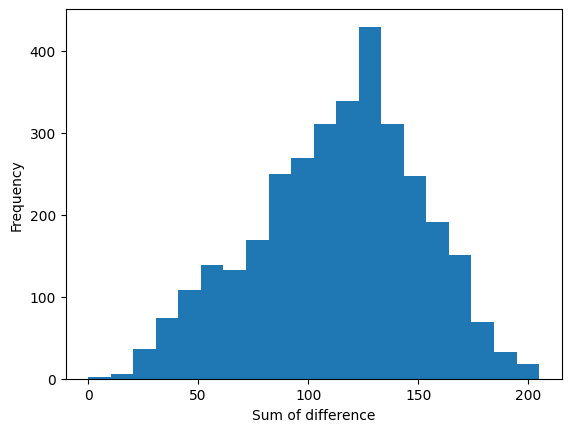

In [ ]:
# plot sum of diff_mat
#plt.hist(dff_filtered_mat.sum(axis=1), bins=20)
plt.hist(diff_mat.sum(axis=1), bins=20)
plt.xlabel('Sum of difference')
plt.ylabel('Frequency')
plt.show()

8.931381518755718
3.877648465468543
57
2


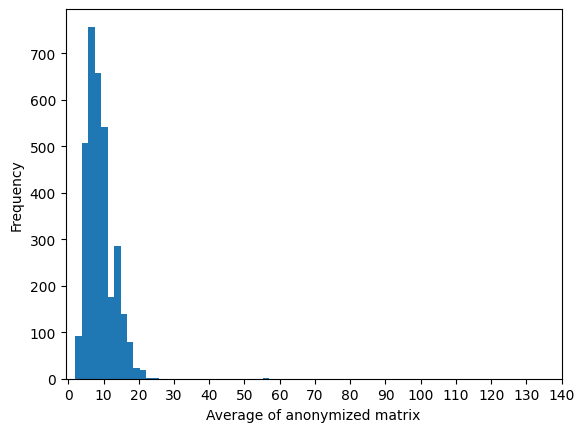

In [ ]:
# sum of anonymized_mat (row)
#ave_anonymized_mat = anonymized_mat.mean(axis=1)
sum_anonymized_mat = anonymized_mat.sum(axis=1)
# print stats
print(sum_anonymized_mat.mean())
print(sum_anonymized_mat.std())
print(sum_anonymized_mat.max())
print(sum_anonymized_mat.min())

# plot

plt.hist(sum_anonymized_mat, bins=30)
#plt.xticks(np.arange(min(sum_anonymized_mat), max(sum_anonymized_mat)+1, 10))  # 目盛りの間隔を1に設定
plt.xticks(np.arange(0, 150, 10))
plt.xlabel('Average of anonymized matrix')
plt.ylabel('Frequency')
plt.show()

46.53827386398292
25.501549903146326
120
10


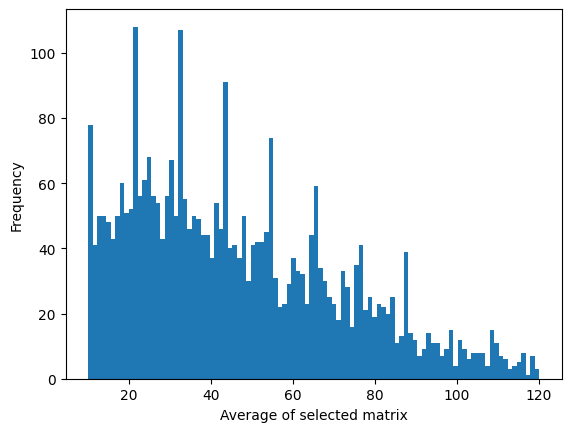

In [ ]:
sum_selected_X = selected_X.sum(axis=1)
# print stats

print(sum_selected_X.mean())
print(sum_selected_X.std())
print(sum_selected_X.max())
print(sum_selected_X.min())

plt.hist(sum_selected_X, bins=100)
#plt.xticks(np.arange(min(sum_anonymized_mat), max(sum_anonymized_mat)+1, 20))  # 目盛りの間隔を1に設定

plt.xlabel('Average of selected matrix')
plt.ylabel('Frequency')
plt.show()

In [1]:
dict_path = 'anonymized_data/negated_test_final_normalized_dict.pkl'
anonymized_data_path = 'anonymized_data/negated_test_anonymized_data.pkl'
sample_data_path = 'anonymized_data/negated_test_sampled_data.pkl'
sample_neighborhood_path = 'anonymized_data/negated_test_sample_neighbor_dict.pkl'

In [2]:
# open all
import pickle

with open(dict_path, 'rb') as f:
    final_normalized_dict = pickle.load(f)
with open(anonymized_data_path, 'rb') as f:
    anonymized_data = pickle.load(f)
with open(sample_data_path, 'rb') as f:
    sampled_data = pickle.load(f)
with open(sample_neighborhood_path, 'rb') as f:
    sample_neighborhood = pickle.load(f)


In [11]:
len_list = []
for key, data in anonymized_data.items():
    len_list.append(len(data))

import numpy as np
# stats
print(np.mean(len_list))


10.252101323019778


In [8]:
for key, data in sampled_data.items():
    print(len(data))

98
81
26
24
25
31
44
56
65
28
78
24
26
74
32
75
67
38
119
38
28
112
15
36
12
32
29
38
102
69
14
12
17
28
31
15
108
11
27
25
52
96
70
22
82
26
86
17
23
18
84
39
61
15
84
62
80
63
47
62
25
40
120
20
70
26
23
70
58
21
37
17
19
10
26
31
46
32
103
27
19
67
86
43
60
92
51
69
19
33
21
57
22
18
18
26
57
109
28
33


In [12]:
len(anonymized_data)

52229

In [13]:
len(sampled_data)

100